# Gymnasium

Gymnasium is a project that provides an API for all single agent reinforcement learning environments. We will outline the basics of how to use Gymnasium including its four key functions: `make`, `Env.reset`, `Env.step` and `Env.render`.

At the core of Gymnasium is `Env`, a high-level python class representing a markov decision process (MDP). The class provides users the ability generate an initial state, transition / move to new states given an action and the visualise the environment. Alongside `Env`, `Wrapper` are provided to help augment / modify the environment, in particular, the agent observations, rewards and actions taken.

In [ ]:
%%capture
!pip install swig
!pip install "gymnasium[all]"

## Basic Use

Initializing environments is very easy in Gymnasium and can be done via the `make` function:

In [ ]:
import gymnasium as gym

env = gym.make("CartPole-v1")

This function will return an `Env` for users to interact with.


The classic “agent-environment loop” pictured below is simplified representation of reinforcement learning that Gymnasium implements.

<figure>
<center>
<img src='https://gymnasium.farama.org/_images/AE_loop.png' />
</center>
</figure>

### Typical workflow

First, an environment is created using `make` with an additional keyword ``"render_mode"`` that specifies how the environment should be visualised.

After initializing the environment, we `Env.reset` the environment to get the first observation of the environment along with an additional information. For initializing the environment with a particular random seed or options (see the environment documentation for possible values) use the ``seed`` or ``options`` parameters with `reset`.

As we wish to continue the agent-environment loop until the environment ends, which is in an unknown number of timesteps, we define ``episode_over`` as a variable to know when to stop interacting with the environment along with a while loop that uses it.

Next, the agent performs an action in the environment, `Env.step` executes the select actions to update the environment. As a result, the agent receives a new observation from the updated environment along with a reward for taking the action. One such action-observation exchange is referred to as a **timestep**.

However, after some timesteps, the environment may end, this is called the terminal state. In gymnasium, if the environment has terminated, this is returned by `step` as the third variable, ``terminated``.
Similarly, we may also want the environment to end after a fixed number of timesteps, in this case, the environment issues a truncated signal. If either of ``terminated`` or ``truncated`` are ``True`` then we end the episode but in most cases users might wish to restart the environment, this can be done with `env.reset()`.

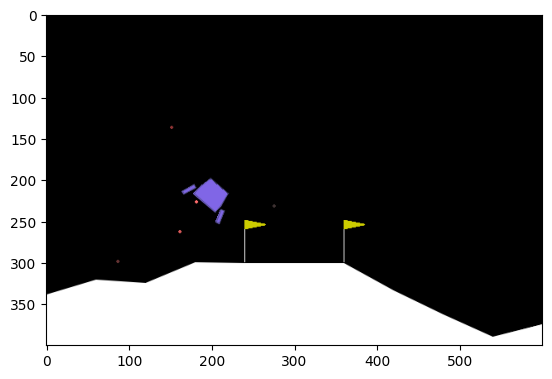

In [ ]:
import gymnasium as gym
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time
env = gym.make("LunarLander-v2", render_mode="rgb_array")
observation, info = env.reset()

for _ in range(80):
    action = env.action_space.sample()  # Randomly sample an action
    observation, reward, terminated, truncated, info = env.step(action)
    img = plt.imshow(env.render())  # Render the image
    display(plt.gcf())    # Display the image
    clear_output(wait=True)  # Clear the output to make the animation
    time.sleep(0.00001)  # Pause a bit before the next frame

    if terminated or truncated:
        observation, info = env.reset()

env.close()

## Action and observation spaces

Every environment specifies the format of valid actions and observations with the `action_space` and `observation_space` attributes. This is helpful for both knowing the expected input and output of the environment as all valid actions and observation should be contained with their respective space.

Importantly, `Env.action_space` and `Env.observation_space` are instances of `Space`, a high-level python class that provides the key functions: `Space.contains` and `Space.sample`. Gymnasium has support for a wide range of spaces that users might need:



- `Box`: describes bounded space with upper and lower limits of any n-dimensional shape.
- `Discrete`: describes a discrete space where ``{0, 1, ..., n-1}`` are the possible values our observation or action can take.
- `MultiBinary`: describes a binary space of any n-dimensional shape.
- `MultiDiscrete`: consists of a series of `Discrete` action spaces with a different number of actions in each element.
- `Text`: describes a string space with a minimum and maximum length
- `Dict`: describes a dictionary of simpler spaces.
- `Tuple`: describes a tuple of simple spaces.
- `Graph`: describes a mathematical graph (network) with interlinking nodes and edges
- `Sequence`: describes a variable length of simpler space elements.


In [ ]:
from gymnasium.spaces import Box, Discrete, Tuple
import numpy as np

Box(low=np.array([-1.0, -2.0]), high=np.array([2.0, 4.0]), dtype=np.float32)

Box([-1. -2.], [2. 4.], (2,), float32)

In [ ]:
observation_space = Discrete(3, start=-1, seed=42)  # {-1, 0, 1}
observation_space.sample() # Generates a single random sample from this space.

-1

In [ ]:
observation_space = Tuple((Discrete(2), Box(-1, 1, shape=(2,))), seed=42)
observation_space.sample()

(0, array([-0.3991573 ,  0.21649833], dtype=float32))

For more example usage of spaces, see their [documentation](https://gymnasium.farama.org/api/spaces/) along with utility functions.

## Modifying the environment

Wrappers are a convenient way to modify an existing environment without having to alter the underlying code directly.

Gymnasium already provides many commonly used wrappers. Some examples:

- `TimeLimit`: Issues a truncated signal if a maximum number of timesteps has been exceeded (or the base environment has issued a truncated signal).
- `ClipAction`: Clips any action passed to ``step`` such that it lies in the base environment's action space.
- `RescaleAction`: Applies an affine transformation to the action to linearly scale for a new low and high bound on the environment.
- `TimeAwareObservation`: Add information about the index of timestep to observation.

Most environments that are generated via `gymnasium.make` will already be wrapped by default using the `TimeLimit`, `OrderEnforcing` and `PassiveEnvChecker`.

In order to wrap an environment, you must first initialize a base environment. Then you can pass this environment along with (possibly optional) parameters to the wrapper's constructor:

In [ ]:
from gymnasium.wrappers import FlattenObservation, RescaleAction, TimeAwareObservation
base_env = gym.make("CarRacing-v2")
base_env.action_space


Box([-1.  0.  0.], 1.0, (3,), float32)

In [ ]:
wrapped_env = RescaleAction(base_env, min_action=0, max_action=1)
wrapped_env.action_space

Box(0.0, 1.0, (3,), float32)

In [ ]:
base_env = gym.make("CartPole-v1")
base_env.reset()

(array([-0.04006759, -0.01189244,  0.04619108,  0.01103577], dtype=float32),
 {})

In [ ]:
env = TimeAwareObservation(base_env)
env.reset()

(array([-0.03463158, -0.00567901, -0.00964559, -0.01377966,  0.        ]), {})

In [ ]:
env.step(env.action_space.sample())[0]

array([-0.03474516, -0.20066132, -0.00992119,  0.27584442,  1.        ])

In [ ]:
env = gym.make("CarRacing-v2")
env.observation_space.shape

(96, 96, 3)

In [ ]:
env = FlattenObservation(env)
env.observation_space.shape

(27648,)

You can access the environment underneath the **first** wrapper by using the `gymnasium.Wrapper.env` attribute. As the `gymnasium.Wrapper` class inherits from `gymnasium.Env` then `gymnasium.Wrapper.env` can be another wrapper.

In [ ]:
wrapped_env.env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CarRacing<CarRacing-v2>>>>>

If you want to get to the environment underneath **all** of the layers of wrappers, you can use the `gymnasium.Wrapper.unwrapped` attribute.

In [ ]:
wrapped_env.unwrapped

<gymnasium.envs.box2d.car_racing.CarRacing>

There are three common things you might want a wrapper to do:

- Transform actions before applying them to the base environment

- Transform observations that are returned by the base environment

- Transform rewards that are returned by the base environment

Such wrappers can be easily implemented by inheriting from `gymnasium.ActionWrapper`,` gymnasium.ObservationWrapper`, or `gymnasium.RewardWrapper` and implementing the respective transformation. If you need a wrapper to do more complicated tasks, you can inherit from the `gymnasium.Wrapper` class directly.


### Example: normalize actions

It is usually a good idea to normalize observations and actions before giving it to the agent, this prevents this [hard to debug issue](https://github.com/hill-a/stable-baselines/issues/473).

In this example, we are going to normalize the action space of *Pendulum-v1* so it lies in [-1, 1] instead of [-2, 2].

Note: here we are dealing with continuous actions, hence the `gym.Box` space

In [ ]:
import numpy as np


class NormalizeActionWrapper(gym.Wrapper):
    """
    :param env: (gym.Env) Gym environment that will be wrapped
    """

    def __init__(self, env):
        # Retrieve the action space
        action_space = env.action_space
        assert isinstance(
            action_space, gym.spaces.Box
        ), "This wrapper only works with continuous action space (spaces.Box)"
        # Retrieve the max/min values
        self.low, self.high = action_space.low, action_space.high

        # We modify the action space, so all actions will lie in [-1, 1]
        env.action_space = gym.spaces.Box(
            low=-1, high=1, shape=action_space.shape, dtype=np.float32
        )

        # Call the parent constructor, so we can access self.env later
        super(NormalizeActionWrapper, self).__init__(env)

    def rescale_action(self, scaled_action):
        """
        Rescale the action from [-1, 1] to [low, high]
        (no need for symmetric action space)
        :param scaled_action: (np.ndarray)
        :return: (np.ndarray)
        """
        return self.low + (0.5 * (scaled_action + 1.0) * (self.high - self.low))

    def reset(self, **kwargs):
        """
        Reset the environment
        """
        return self.env.reset(**kwargs)

    def step(self, action):
        """
        :param action: ([float] or int) Action taken by the agent
        :return: (np.ndarray, float,bool, bool, dict) observation, reward, final state? truncated?, additional informations
        """
        # Rescale action from [-1, 1] to original [low, high] interval
        rescaled_action = self.rescale_action(action)
        obs, reward, terminated, truncated, info = self.env.step(rescaled_action)
        return obs, reward, terminated, truncated, info

#### Test before rescaling actions

In [ ]:
original_env = gym.make("Pendulum-v1")

print(original_env.action_space.low)
for _ in range(10):
    print(original_env.action_space.sample())

[-2.]
[-0.4710181]
[0.39280972]
[-1.3493373]
[1.1008148]
[-0.3110773]
[-0.7836835]
[0.8927286]
[-1.5097785]
[0.11178854]
[-0.39259312]


#### Test the NormalizeAction wrapper

In [ ]:
env = NormalizeActionWrapper(gym.make("Pendulum-v1"))

print(env.action_space.low)

for _ in range(10):
    print(env.action_space.sample())

[-1.]
[0.9980464]
[0.16381392]
[0.15574437]
[-0.99977094]
[0.19786243]
[0.66842103]
[-0.92170566]
[-0.84871]
[0.2052033]
[-0.8525819]


## Handling Time Limits

- **Termination** refers to the episode ending after reaching a terminal state that is defined as part of the environment definition.
Examples are - task success, task failure, robot falling down etc. Notably, this also includes episodes ending in finite-horizon environments due to a time-limit

- **Truncation** - Truncation refers to the episode ending after an externally defined condition (that is outside the scope of the Markov Decision Process). This could be a time-limit, a robot going out of bounds etc. This is different from time-limits in finite horizon environments as the agent in this case has no idea about this time-limit.

### Why the distinction between termination and truncation is important

**When an episode ends due to termination we don’t bootstrap, when it ends due to truncation, we bootstrap.**



Here is an illustrative example and not part of any specific algorithm:

```python
# INCORRECT
vf_target = rew + gamma * (1 - done) * vf_next_state

# CORRCET
vf_target = rew + gamma * (1 - terminated) * vf_next_state
```



From v0.26 onwards, Gymnasium’s `env.step` API returns both termination and truncation information explicitly

## Make your own custom environment

In practice this is how a gym environment looks like. Here, we have implemented a simple grid world were the agent must learn to go always left.

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces


class GoLeftEnv(gym.Env):
    """
    Custom Environment that follows gym interface.
    This is a simple env where the agent must learn to go always left.
    """

    # Because of google colab, we cannot implement the GUI ('human' render mode)
    metadata = {"render_modes": ["console"]}

    # Define constants for clearer code
    LEFT = 0
    RIGHT = 1

    def __init__(self, grid_size=10, render_mode="console"):
        super(GoLeftEnv, self).__init__()
        self.render_mode = render_mode

        # Size of the 1D-grid
        self.grid_size = grid_size
        # Initialize the agent at the right of the grid
        self.agent_pos = grid_size - 1

        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions, we have two: left and right
        n_actions = 2
        self.action_space = spaces.Discrete(n_actions)
        # The observation will be the coordinate of the agent
        # this can be described both by Discrete and Box space
        self.observation_space = spaces.Box(
            low=0, high=self.grid_size, shape=(1,), dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        """
        Important: the observation must be a numpy array
        :return: (np.array)
        """
        super().reset(seed=seed, options=options)
        # Initialize the agent at the right of the grid
        self.agent_pos = self.grid_size - 1
        # here we convert to float32 to make it more general (in case we want to use continuous actions)
        return np.array([self.agent_pos]).astype(np.float32), {}  # empty info dict

    def step(self, action):
        if action == self.LEFT:
            self.agent_pos -= 1
        elif action == self.RIGHT:
            self.agent_pos += 1
        else:
            raise ValueError(
                f"Received invalid action={action} which is not part of the action space"
            )

        # Account for the boundaries of the grid
        self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size)

        # Are we at the left of the grid?
        terminated = bool(self.agent_pos == 0)
        truncated = False  # we do not limit the number of steps here

        # Null reward everywhere except when reaching the goal (left of the grid)
        reward = 1 if self.agent_pos == 0 else 0

        # Optionally we can pass additional info, we are not using that for now
        info = {}

        return (
            np.array([self.agent_pos]).astype(np.float32),
            reward,
            terminated,
            truncated,
            info,
        )

    def render(self):
        # agent is represented as a cross, rest as a dot
        if self.render_mode == "console":
            print("." * self.agent_pos, end="")
            print("x", end="")
            print("." * (self.grid_size - self.agent_pos))

    def close(self):
        pass

### Validate the environment

Gymnasium provides a [helper](https://gymnasium.farama.org/api/utils/#gymnasium.utils.env_checker.check_env) to check that your environment follows the Gym interface.

In [ ]:
from gymnasium.utils.env_checker import check_env
env = GoLeftEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True, skip_render_check=True)

/home/itaysegev/miniconda3/envs/CLAI/lib/python3.12/site-packages/gymnasium/utils/env_checker.py:274: UserWarning: WARN: `check_env(warn=...)` parameter is now ignored.
  logger.warn("`check_env(warn=...)` parameter is now ignored.")


### Testing the environment

In [ ]:
env = GoLeftEnv(grid_size=10)

obs, _ = env.reset()
env.render()

print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())

GO_LEFT = 0
# Hardcoded best agent: always go left!
n_steps = 20
for step in range(n_steps):
    print(f"Step {step + 1}")
    obs, reward, terminated, truncated, info = env.step(GO_LEFT)
    done = terminated or truncated
    print("obs=", obs, "reward=", reward, "done=", done)
    env.render()
    if done:
        print("Goal reached!", "reward=", reward)
        break

.........x.
Box(0.0, 10.0, (1,), float32)
Discrete(2)
0
Step 1
obs= [8.] reward= 0 done= False
........x..
Step 2
obs= [7.] reward= 0 done= False
.......x...
Step 3
obs= [6.] reward= 0 done= False
......x....
Step 4
obs= [5.] reward= 0 done= False
.....x.....
Step 5
obs= [4.] reward= 0 done= False
....x......
Step 6
obs= [3.] reward= 0 done= False
...x.......
Step 7
obs= [2.] reward= 0 done= False
..x........
Step 8
obs= [1.] reward= 0 done= False
.x.........
Step 9
obs= [0.] reward= 1 done= True
x..........
Goal reached! reward= 1
